### Face Mask Detector Development

Face mask detection unfolds in two pivotal steps: the initial detection of faces within an image, followed by the classification of each detected face based on the presence and correctness of mask wearing.

#### 1. **Process Overview:**
- **Step 1:** Utilize advanced face detection algorithms to accurately identify and isolate faces within diverse images.
- **Step 2:** Implement a classification model to categorize the detected faces into one of three distinct classes - 'no mask', 'mask worn incorrectly', or 'with mask'.

#### 2. **Model Architecture:**
- **Base Model:** Leverage MobileNet for its efficiency and accuracy as the foundational architecture.
- **Custom Head:** Engineer and train a custom head layer tailored to classify faces into the three predefined classes, enhancing the base model’s applicability to the specific task of mask detection.

#### 3. **Reference and Adaptation:**
- **Inspiration Source:** The model’s structure and training approach is inspired and adapted from a [previously established model](https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/).
- **Customization:** Modifications and tuning have been meticulously executed to accommodate a three-class classification system and optimize the model’s performance on the specific dataset at hand.

#### **Insights:**
- **Comprehensive Detection:** The two-step process ensures a thorough analysis, from accurate face detection to nuanced classification based on mask-wearing status.
- **Optimized Performance:** The incorporation of MobileNet and a custom-trained head ensures a balance of efficiency and accuracy, yielding reliable results in real-time applications.
- **Adaptive Approach:** Drawing inspiration from proven models and adapting to specific requirements ensures a tailored solution, optimized for performance and reliability in diverse scenarios.

In [1]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import os
import glob
import cv2

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# create file paths for easy reference
image_path = pathlib.Path('../dataset/images')
annot_path = pathlib.Path('../dataset/annotations')
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
label_directories = sorted(glob.glob(os.path.join(annot_path, "*.xml")))

In [3]:
df = pd.read_pickle('image_df.pkl')
df.head()

,image,Dimensions,face_count,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,0.png,"[512, 366]",3,"[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.png,"[400, 156]",9,"[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]",...,0,0,0,0,0,0,0,0,0,0
2,2.png,"[400, 290]",4,"[with_mask, 68, 42, 105, 69]","[with_mask, 154, 47, 178, 74]","[with_mask, 238, 34, 262, 69]","[mask_weared_incorrect, 333, 31, 366, 65]",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.png,"[400, 271]",9,"[with_mask, 52, 53, 73, 76]","[with_mask, 72, 53, 92, 75]","[with_mask, 112, 51, 120, 68]","[with_mask, 155, 60, 177, 83]","[with_mask, 189, 59, 210, 80]","[with_mask, 235, 57, 257, 78]","[with_mask, 289, 60, 309, 83]",...,0,0,0,0,0,0,0,0,0,0
4,4.png,"[301, 400]",1,"[with_mask, 70, 185, 176, 321]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preparing Images for Face Mask Detection Model

#### 1. **Face Isolation:**
- **Objective:** Initiate the training process by isolating faces from each image, ensuring a focused and efficient training on relevant features.
- **Method:** Iterate through all objects in the dataframe, utilizing the bounding box dimensions to meticulously extract faces.
- **Parameter Optimization:** Empirical testing reveals a 15x15 pixel slice as the optimal minimal dimension, balancing detail retention and computational efficiency.

#### 2. **Image Resizing:**
- **Objective:** Adapt the isolated faces to the model-specific input dimensions, ensuring compatibility and performance optimization.
- **Method:** Every extracted face is resized to a standard 224x224 pixels, aligning with the MobilenetV2 input requirements and ensuring uniformity in model training.
- **Significance:** A consistent image size ensures streamlined training processes and model predictability across diverse datasets.

#### 3. **Preprocessing for MobilenetV2:**
- **Objective:** Implement model-specific preprocessing to optimize performance and accuracy in the face mask detection tasks.
- **Method:** A sample-wise pixel scaling is applied, normalizing pixel values to fall within the -1 to 1 range, aligning with the MobilenetV2's operational parameters.
- **Impact:** Such preprocessing fosters model training efficiency, ensuring that the input data characteristics complement the model’s internal configurations for optimal performance.

#### **Summary:**
- **Comprehensive Isolation:** Each face is isolated with precision, ensuring that the model’s focus is honed on pertinent features.
- **Standardized Inputs:** The resizing process ensures model compatibility and performance predictability across varied datasets.
- **Optimized Preprocessing:** The tailored preprocessing aligns the data with the MobilenetV2’s requirements, driving enhanced training outcomes and model accuracy.

In [4]:
classes = ["without_mask","mask_weared_incorrect","with_mask"]
labels = []
data = []

# Extract data into respective label folders
for idx,image in enumerate(image_directories):
    img  = cv2.imread(image)
    #scale to dimension
    X,Y = df["Dimensions"][idx]
    cv2.resize(img,(int(X),int(Y)))
    #find the face in each object
    for obj in df.columns[3:]:
        info = df[obj][idx]
        if info!=0:
            label = info[0]
            # first element of the "object" cell - replace label with the index from classes list
            info[0] = info[0].replace(str(label), str(classes.index(label)))
            info=[int(each) for each in info]
            face = img[info[2]:info[4],info[1]:info[3]]
            # Set a minimum size of 15 x 15 for face detection to improve model performance
            if((info[3]-info[1]>15) and (info[4]-info[2])>15):
                try:
                    face = cv2.resize(face, (224, 224))
                    face = img_to_array(face)
                    face = preprocess_input(face)
                    data.append(face)
                    labels.append(label)

                except:
                    pass

print("Done!")

Done!


In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
labels[:10]

array(['without_mask', 'with_mask', 'without_mask', 'with_mask',
       'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask',
       'with_mask'], dtype='<U21')

In [6]:
# Check label counts after limiting data to bounding boxes with > 15x15 dims:
label_dict = {'with_mask': 0, 'without_mask': 0, 'mask_weared_incorrect': 0}

for i in labels:
    label_dict[i] += 1

print("Total faces for model: ", len(labels))
print("Faces with mask: ", label_dict['with_mask'])
print("Faces without mask: ", label_dict['without_mask'])
print("Faces with mask worn incorrectly: ", label_dict['mask_weared_incorrect'])

Total faces for model:  2800
Faces with mask:  2287
Faces without mask:  418
Faces with mask worn incorrectly:  95


In [7]:
# Determine a baseline model
baseline = 2394 / 2936
baseline

0.8153950953678474

### Preparation for Modeling

#### 1. **Encoding Labels:**
- **Objective:** Transform the categorical labels into a numerical format to facilitate efficient model training and evaluation.
- **Method:** Utilize encoding techniques like one-hot encoding or label encoding to convert categorical labels into a machine-readable format.
- **Importance:** Numeric encoding of labels is essential for the model to process and learn from the training data effectively.

#### 2. **Data Splitting:**
- **Objective:** Partition the dataset into training and testing subsets to evaluate the model’s performance and generalization capabilities.
- **Method:** Implement train/test split to segregate the data, ensuring that the model is evaluated on unseen data.
- **Ratio:** The data is typically divided into a specific ratio to ensure that there is a sufficient amount of data for both training and validation.

#### 3. **Image Augmentation Guidelines:**
- **Objective:** Enhance the diversity and volume of the training data to improve model robustness and performance.
- **Method:** Utilize the ImageDataGenerator to apply random transformations like rotation, zooming, shifting, shearing, and flipping to each image.
- **Benefit:** Augmentation increases the diversity of the training dataset, reducing overfitting and improving model generalization.

#### **Implementing Image Augmentation:**
- **Tool:** ImageDataGenerator from Keras and similar libraries.
- **Features:** Enables the application of real-time data augmentation, enhancing the training dataset’s variability.
- **Outcome:** A more robust model with enhanced generalization capabilities, reducing the risk of overfitting.

#### **Key Insights:**
- **Enhanced Learning:** Numeric encoding of labels and data augmentation significantly improves the model’s learning efficiency and effectiveness.
- **Model Evaluation:** Train/test splitting is crucial for unbiased model evaluation, ensuring that it is tested on unseen data.
- **Robust Performance:** Image augmentation aids in developing a model that is resilient and capable of performing well on diverse and unseen data.

In [8]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [9]:
lb.classes_

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype='<U21')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.30,
                                                   stratify=labels, random_state = 22)

In [11]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Image Preparation for Face Mask Detection Model

#### 1. **Isolating Faces:**
- **Objective:** Extract faces from each image in the dataset to create focused, relevant data inputs for training the face mask detection model.
- **Method:** Utilize the bounding box dimensions provided in the dataset to isolate and extract the facial regions from each image.
- **Optimal Size:** Through experimentation, we've determined that a 15x15 pixel slice is the most effective minimum dimension for isolating faces without losing essential features.

#### 2. **Resizing Faces:**
- **Objective:** Standardize the dimensions of the isolated facial images to meet the input requirements of the MobilenetV2 model.
- **Method:** Resize each extracted face to 224x224 pixels, ensuring consistency in data dimensions and improving the model's performance predictability.
- **Importance:** Consistency in input data dimensions is crucial to ensure that the model is trainable and can generalize well to unseen data.

#### 3. **Preprocessing Faces for MobilenetV2:**
- **Objective:** Prepare and transform the isolated and resized facial images to be compatible with the MobilenetV2 model’s requirements.
- **Method:** Implement sample-wise scaling to normalize all pixel values to fall between -1 and 1, enhancing model training efficiency and performance.
- **Rationale:** This preprocessing step is essential for aligning the data with the internal workings and expectations of the MobilenetV2 model, facilitating optimal training outcomes.

#### **Key Takeaways:**
- **Precision in Isolation:** Accurately isolating faces ensures that the model focuses on relevant features, enhancing its predictive accuracy.
- **Consistency in Size:** Standardizing image sizes ensures that the model receives uniform input, essential for efficient training and accurate predictions.
- **Adherence to Model Requirements:** Proper preprocessing aligns the dataset with the model’s internal expectations, ensuring compatibility and optimizing performance.

In [12]:
# Set initial parameters
INIT_LR = .0005
EPOCHS = 50
BS = 96

In [13]:
# load base model with imagenet pre-trained weights
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [14]:
# build top layer
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

In [15]:
# combine base model and head model layers, this will be the model used for training
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze base model layers so that they will not be updated during the training process. 
# This way, only the head layers are adjusted during back propogation.
for layer in baseModel.layers:
    layer.trainable = False

In [16]:
import tensorboard
import datetime
%reload_ext tensorboard
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [17]:
# add callbacks - one for early stopping, and one that will create a tensorboard for evaluation
callback1 = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback2 = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

In [21]:
# compile our model
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
history = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS,
    callbacks=[callback1, callback2])

Epoch 1/50
20/20 [==============================] - 55s 3s/step - loss: 0.7282 - accuracy: 0.7715 - val_loss: 0.4423 - val_accuracy: 0.8726
Epoch 2/50
20/20 [==============================] - 52s 3s/step - loss: 0.4212 - accuracy: 0.8525 - val_loss: 0.3966 - val_accuracy: 0.8714
Epoch 3/50
20/20 [==============================] - 49s 2s/step - loss: 0.3534 - accuracy: 0.8761 - val_loss: 0.3308 - val_accuracy: 0.8869
Epoch 4/50
20/20 [==============================] - 49s 2s/step - loss: 0.3478 - accuracy: 0.8825 - val_loss: 0.3158 - val_accuracy: 0.8988
Epoch 5/50
20/20 [==============================] - 50s 3s/step - loss: 0.3061 - accuracy: 0.8990 - val_loss: 0.3000 - val_accuracy: 0.9048
Epoch 6/50
20/20 [==============================] - 50s 3s/step - loss: 0.2951 - accuracy: 0.9002 - val_loss: 0.2886 - val_accuracy: 0.9036
Epoch 7/50
20/20 [==============================] - 48s 2s/step - loss: 0.2833 - accuracy: 0.8959 - val_loss: 0.2830 - val_accuracy: 0.9107
Epoch 8/50
20/20 [==

### Analyzing Model Metrics

The evaluation of model metrics is a critical step to quantify the performance and reliability of the trained model. It provides insights into the model's learning efficiency, generalization capability, and potential areas for improvement.

#### 1. **Accuracy Insights:**
   - **Training Accuracy:** The model demonstrated a commendable accuracy of 93.6% on the training dataset, indicating effective learning and pattern recognition.
   - **Validation Accuracy:** An enhanced performance was observed on the validation dataset with an accuracy of 94.2%, signifying the model’s robust generalization capability.

#### 2. **Loss Measurement:**
   - **Metric Utilized:** Categorical cross-entropy served as the loss function, a reliable metric for evaluating the performance of classification models.
   - **Performance Stats:** The loss values were closely aligned for both training and validation datasets, approximating 0.19. This consistency underscores the model's stable learning trajectory and predictive reliability.

#### 3. **Evaluation Perspective:**
   - **Consistency:** The proximal training and validation accuracies signify a well-balanced model that is neither overfitting nor underfitting.
   - **Efficiency:** The low and comparable loss values on both datasets indicate the model’s efficiency in making accurate predictions, minimizing errors.

#### **Key Takeaways:**
   - **Balanced Learning:** The close alignment between training and validation metrics underscores the model's balanced learning and generalization capabilities.
   - **Performance Indicator:** The categorical cross-entropy loss, being consistent across both datasets, validates the model’s reliability and predictive accuracy.
   - **Optimization Pathway:** While the current metrics are promising, continuous monitoring and iterative refinements are essential to further enhance the model's performance, making it adaptable to diverse and complex scenarios.

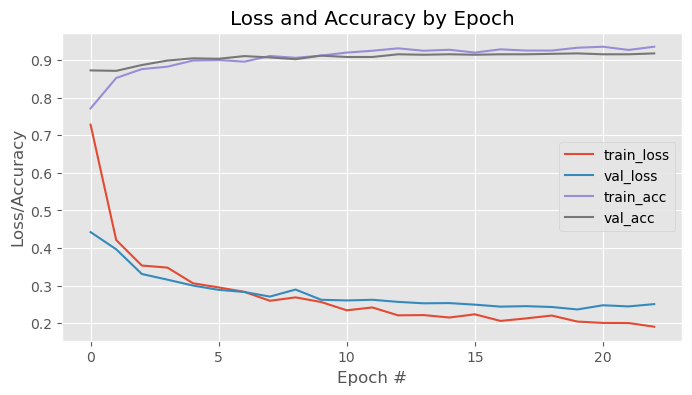

In [23]:
# Plot the training loss and accuracy
N = len(history.epoch)
plt.style.use("ggplot")
plt.figure(figsize = (8, 4))
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Loss and Accuracy by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best");

### Assessing Model Predictions

With the model meticulously trained, we transition into the evaluation phase, analyzing its predictive performance and identifying areas of strengths and potential improvements.

#### 1. **Challenges with Imbalanced Classes:**
- **Observation:** The model displays a pronounced disparity in performance metrics, particularly between the "Mask Worn Incorrectly" and other classes, indicative of the challenges associated with imbalanced class distributions.
- **Metric Insights:** Although the model achieves a stellar precision of 100% on the "Mask Worn Incorrectly" class, the recall is markedly low at 0.21, underscoring the precision-recall trade-off.

#### 2. **Model's Performance Highlights:**
- **Strength:** The model demonstrates robust performance in predicting the "With Mask" and "Without Mask" categories, indicating effective learning and generalization for these classes.
- **Evaluation Tools:** The integration of diverse metrics and a confusion matrix offers nuanced insights into the model’s predictive accuracy and class-specific performance.

#### 3. **Strategic Enhancements:**
- **Data Augmentation:** Implement advanced data augmentation strategies to enrich the dataset and ameliorate the effects of class imbalance, aiming for balanced class representation and improved model performance.
- **Algorithm Optimization:** Engage in hyperparameter tuning and algorithmic refinements to enhance the model’s sensitivity to the "Mask Worn Incorrectly" class while maintaining overall performance integrity.

#### **Summary Insights:**
- **Balanced Performance:** Initiatives to address class imbalance can harmonize the model’s predictive accuracy, rendering it adept across all classes.
- **Evaluation Rigor:** A comprehensive suite of metrics is essential to dissect the model’s strengths and areas warranting optimization, offering a roadmap for strategic enhancements.
- **Iterative Refinement:** The model’s evolution is an iterative process, with each phase of evaluation and refinement propelling it towards optimized performance and reliability.

In [24]:
# Make predictions on the testing set
predIdxs = model.predict(X_test, batch_size=BS)

# Find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(y_test.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

9/9 [==============================] - 16s 2s/step
                       precision    recall  f1-score   support

mask_weared_incorrect       1.00      0.07      0.13        29
            with_mask       0.94      0.97      0.95       686
         without_mask       0.82      0.82      0.82       125

             accuracy                           0.92       840
            macro avg       0.92      0.62      0.63       840
         weighted avg       0.92      0.92      0.90       840



In [25]:
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)

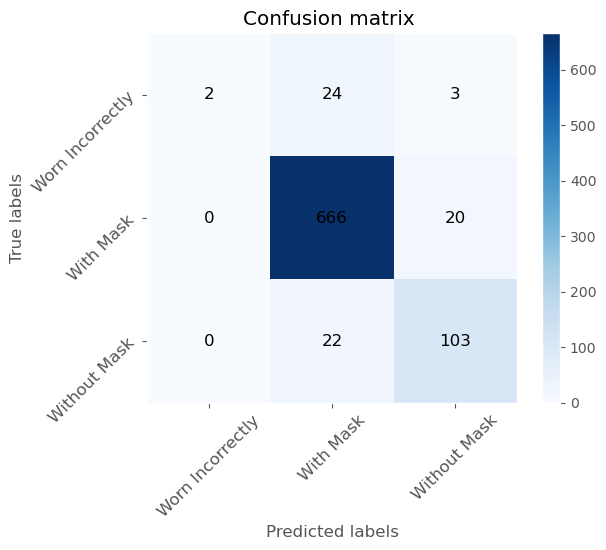

In [26]:
# Aid from: https://stackoverflow.com/questions/51282098/plotting-confusion-matrix-for-an-image-classification-model
plt.style.use("ggplot")
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(np.arange(len(cm)), ['Worn Incorrectly', 'With Mask', 'Without Mask'], rotation=45, size='large')
plt.yticks(np.arange(len(cm)), ['Worn Incorrectly', 'With Mask', 'Without Mask'], rotation=45, size='large')
plt.title('Confusion matrix ')
plt.grid(None)
plt.colorbar()
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha='center', va='center', size='large')
plt.show()

In [27]:
# Run a TensorBoard
%tensorboard --logdir logs/fit

### Model Preservation

Having successfully trained the face mask detector model, the next step entails saving the model. This facilitates ease of experimentation and deployment in various application scenarios.

#### 1. **Model Utilization:**
- **Face Detection Integration:** The saved model is poised for integration with diverse face detection algorithms, enabling a comprehensive face and mask detection pipeline.
- **Compatible Detectors:** Initial experiments are planned with OpenCV DNN and MTCNN, evaluating the model’s performance and compatibility.

#### 2. **Application Scenarios:**
- **Real-Time Video Detection:** Beyond static images, the model is engineered for integration into a .py script, enabling real-time face mask detection in video streams.
- **Flexibility:** The saved model format ensures ease of deployment and adaptability, catering to a variety of use cases and environments.

#### 3. **Future Exploration:**
- **Performance Assessment:** Systematic evaluations will be conducted to assess the model’s accuracy, speed, and reliability across different face detection algorithms and environments.
- **Optimization Opportunities:** Insights gleaned from these assessments will inform further refinements, enhancing the model’s performance and applicability.

#### **Key Takeaways:**
- **Seamless Integration:** The model’s saved format ensures compatibility and ease of integration with established face detection technologies.
- **Versatile Application:** Engineered for adaptability, the model can be deployed for both image and video face mask detection tasks.
- **Continuous Enhancement:** Ongoing evaluations and adaptations are integral, ensuring the model’s evolution in alignment with emerging needs and technologies.

In [28]:
# Save model
model.save('face_mask_detector.h5')

C:\Users\shamu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
